In [1]:
import os
os.chdir('../../')
os.getcwd()

'/data/jeff-law/projects/toxcast/2023-03-toxcast/tox_signaling_networks'

In [2]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))

# Extra settings for the matplotlib text to be editable in inkscape
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)
%matplotlib inline  

python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
matplotlib version: 3.1.1
seaborn version: 0.9.0
pandas version: 1.1.2
numpy version: 1.17.0


In [94]:
# first load the selected enriched terms, and the hits enriched terms
results_dir = "outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats"
out_dir = results_dir+'/go-analysis-k150/viz'
hits_file = "%s/go-analysis/389chemical-hits-sig-terms-bonferroni-c0_05.tsv" % (results_dir)
revigo_files = {
    # "C75330755": "%s/go-analysis-k150/revigo/lovastatin/Revigo_BP_Table_lovastatin_t0_5.tsv" % results_dir,
#     "C6893023": "%s/revigo/t3/t3-revigo.csv" % results_dir,
    "C80057": "%s/go-analysis-k150/revigo/bpa/Revigo_BP_Table_bpa_t0_5.tsv" % results_dir,
}
revigo_selected_terms_files = {
    # "C75330755": "%s/go-analysis-k150/revigo/lovastatin/lovastatin-selected-terms.tsv" % results_dir,
#     "C6893023": "%s/revigo/t3/t3-revigo-selected-terms.csv" % results_dir,
    "C80057": "%s/go-analysis-k150/revigo/bpa/bpa-selected-terms.tsv" % results_dir,
}

hits_df = pd.read_csv(hits_file, sep='\t', index_col=0)
hits_df.head()

,Term,GOID,Bonferroni
Chemical,,,
C101724,positive regulation of transcription from RNA ...,GO:0045944,0.000311
C101724,xenobiotic catabolic process,GO:0042178,0.000536
C101724,"positive regulation of transcription, DNA-temp...",GO:0045893,0.001457
C101724,positive regulation of gene expression,GO:0010628,0.002983
C101724,hormone-mediated signaling pathway,GO:0009755,0.005538


In [14]:
sig_chem_file = "inputs/versions/2018_01-toxcast-d2d-p1_5-u1_25//sig-chemicals.txt"
S = pd.read_csv(sig_chem_file, header=None, skiprows=1, squeeze=True)
S

0         C1120010
1          C118752
2          C130201
3          C151213
4        C15972608
          ...     
192         C98293
193    CNOCAS47334
194    CNOCAS47353
195    CNOCAS47377
196    CNOCAS47387
Name: 0, Length: 197, dtype: object

In [85]:
# also read in the frequency of the terms among the networks
terms_file = "%s/go-analysis-k150/389chemicals-sig-terms-bonferroni-c0_05.tsv" % (results_dir)
df_terms = pd.read_csv(terms_file, sep='\t')
df_terms.head(2)
print(len(df_terms))
df_terms = df_terms[df_terms.Bonferroni < 0.01]
print(len(df_terms))
# limit to sig chemical networks
df_terms = df_terms[df_terms.Chemical.isin(S)]
print(len(df_terms))
print(df_terms.Chemical.nunique())

df_counts = df_terms[['Term', 'GOID']].value_counts().reset_index()
df_counts.columns = ['term_name', 'term', 'count']
df_counts.set_index('term', inplace=True)
df_counts.head()
# counts_file = "%s/go-analysis-k150/389chemicals-sig-terms-bonferroni-c0_05-counts.tsv" % (results_dir)
# df_counts = pd.read_csv(counts_file, sep='\t', header=None, names=['term_name', 'term', 'count'], index_col='term')
# df_counts.head()

27918
21830
12013
197


,term_name,count
term,,
GO:0010628,positive regulation of gene expression,197
GO:0043066,negative regulation of apoptotic process,197
GO:0045893,"positive regulation of transcription, DNA-temp...",196
GO:0045944,positive regulation of transcription from RNA ...,196
GO:0006468,protein phosphorylation,194


In [ ]:
# also read in the frequency of the terms among the networks
# counts_file = "%s/go-analysis-k150/389chemicals-sig-terms-bonferroni-c0_01-counts.tsv" % (results_dir)
# df_counts = pd.read_csv(counts_file, sep='\t', header=None, names=['term', 'count'], index_col='term')
# df_counts.head()

In [54]:
df_counts

,term_name,count
term,,
GO:0010628,positive regulation of gene expression,197
GO:0043066,negative regulation of apoptotic process,197
GO:0045893,"positive regulation of transcription, DNA-temp...",196
GO:0045944,positive regulation of transcription from RNA ...,196
GO:0006468,protein phosphorylation,194
...,...,...
GO:0035914,skeletal muscle cell differentiation,1
GO:0048709,oligodendrocyte differentiation,1
GO:0007405,neuroblast proliferation,1


In [95]:
for chem, revigo_file in revigo_files.items():
    print(f"Reading {revigo_file}")
    df = pd.read_csv(revigo_file, sep='\t')
    df.set_index('Name', inplace=True, drop=False)
    df.rename(columns={'Value': 'log10 p-value'}, inplace=True)
    df.set_index('TermID', inplace=True)
    df['count'] = df_counts['count']
    print(len(df))
    df = df[pd.isnull(df['Representative'])]
    print(len(df))
    df_sel = pd.read_csv(revigo_selected_terms_files[chem], sep='\t', index_col='TermID')
    df_sel['selected'] = 1
    df['selected'] = df_sel['selected']
    #     df['description'] = df['description'].apply(lambda x: r"\textbf{%s}" % x)
    # split into two groups, sort the two groups, then put back together
    split_count = df_counts['count'].max() *.75
    print(split_count)
    df2 = df[df['count'] < split_count].sort_values('log10 p-value')
    df3 = df[df['count'] >= split_count].sort_values('log10 p-value')
    df = pd.concat([df2, df3])
    df['log10 p-value'] = abs(df['log10 p-value'])
    # enrichment_heatmap(chem, df, hits_df, results_dir+'go-analysis-k150/viz')
    # df.head()

Reading outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis-k150/revigo/bpa/Revigo_BP_Table_bpa_t0_5.tsv
50
29
147.75


In [82]:
df.head(2)

,Name,log10 p-value,LogSize,Frequency,Uniqueness,Dispensability,Representative,count,selected
TermID,,,,,,,,,
GO:0007169,transmembrane RTK signaling pathway,13.430626,2.621176,2.348502,0.708991,0.005211,NaN,66,1.0
GO:0030335,pos. reg. of cell migration,11.486782,2.719331,2.945483,0.812188,0.049002,NaN,121,1.0


outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis-k150/viz/C80057-full-enrichment-heatmap.pdf


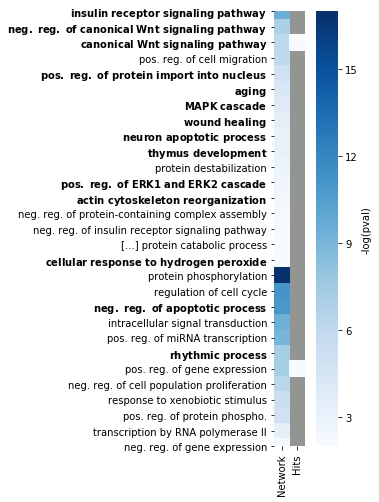

In [96]:
# def enrichment_heatmap(chem, df, hits_df, out_dir):
chem_hits_df = hits_df[hits_df.index == chem].set_index('GOID')
#     df.set_index('term_ID', inplace=True)
df['hits'] = chem_hits_df['Bonferroni']
plot_df = df[['Name', 'log10 p-value', 'hits']].set_index('Name')
plot_df.columns = ["Network", "Hits"]
# plot_df = df[['term_ID', 'log10 p-value']].set_index('term_ID')
plot_df.head()
# now make a heatmap
f, ax = plt.subplots(figsize=(4,8))
# curr_cmap = sns.color_palette('Blues')
# curr_cmap.set_bad(color='gray')
sns.heatmap(plot_df, cmap='Blues', square=True, 
            vmin =2, cbar_kws={'label': '-log(pval)'}, ax=ax)
ax.set_facecolor('xkcd:grey')
plt.ylabel("")

# try to make some labels bold
labels = [l.get_text() for l in ax.get_yticklabels()]
sel_terms = df[df['selected'] == 1]['Name'].values
labels = [' '.join(r"$\bf{%s}$"%t for t in t.split(' ')) if t in sel_terms else t for t in labels]
ax.set_yticklabels(labels)

out_file = "%s/%s-full-enrichment-heatmap.pdf" % (out_dir, chem)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
plt.show()
plt.close()


# Heatmap of terms common to at least 50% of networks

In [127]:
# counts_file = "%s/hits/325chemicals-sig-terms-bonferroni-c0_01-counts.tsv" % (results_dir)
revigo_counts_file = "outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis-k150/197chemicals-sig-terms-bonferroni-c0_01-counts-revigo.tsv"
df = pd.read_csv(revigo_counts_file, sep='\t', index_col=['TermID', 'Name'])
df = df[pd.isnull(df['Representative'])]
df['fraction'] = df['Value'] / 198
print("%d terms" % (len(df)))
df_counts = df
df_counts.head()

24 terms


,,Value,LogSize,Frequency,Uniqueness,Dispensability,Representative,fraction
TermID,Name,,,,,,,
GO:0000122,neg. reg. of transcription by RNA polymerase II,191,2.985875,5.446046,0.752096,0.377298,NaN,0.964646
GO:0000165,MAPK cascade,119,2.336460,1.216490,0.849647,0.201104,NaN,0.601010
GO:0001934,pos. reg. of protein phosphorylation,149,2.852480,4.004280,0.800286,0.321701,NaN,0.752525
GO:0006366,transcription by RNA polymerase II,162,2.552668,2.004956,0.960990,0.160640,NaN,0.818182
GO:0006468,protein phosphorylation,194,2.856729,4.043704,0.858384,-0.000000,NaN,0.979798


In [128]:
# and among the hits
# counts_file = "%s/hits/325chemicals-sig-terms-bonferroni-c0_01-counts.tsv" % (results_dir)
counts_file = "outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/go-analysis/197chemical-hits-sig-terms-bonferroni-c0_01-counts-manual.tsv"
df = pd.read_csv(counts_file, sep='\t', index_col=['TermID', 'Name'])
# df.head()
# df = df[df['eliminated'] == 0]
df['hits_fraction'] = df['value'] / 198
# limit the terms to those in at least 50% or more
df = df[df['hits_fraction'] > 0.33]
print("%d terms" % (len(df)))
df_counts_hits = df
df_counts_hits.head()

3 terms


,,value,hits_fraction
TermID,Name,,
GO:0045944,pos. reg. of transcription from [...],123,0.621212
GO:0030522,intracellular receptor signaling pathway,83,0.419192
GO:0006805,xenobiotic metabolic process,77,0.388889


In [129]:
# now make a heatmap, where we sort by the maximum fraction among hits or net
# df = df_counts[['description', 'fraction']]
# df['hits_fraction'] = df_counts_hits['fraction']
df = pd.concat([df_counts[['fraction']],df_counts_hits[['hits_fraction']]], axis=1)
df['fraction'] = df['fraction'].replace(np.nan,-1)
df['max_frac'] = df.sum(axis=1)
df['fraction'] = df['fraction'].replace(-1,np.nan)
df.sort_values(by='max_frac', inplace=True, ascending=False) 
df.drop(columns='max_frac', inplace=True)
df.columns = ['Networks', 'Hits']
df.index = df.index.get_level_values('Name')
# df.index = [x.replace('negative','neg.').replace('positive','pos.').replace('regulation', 'reg.') for x in df.index]
df.head()


,Networks,Hits
Name,,
pos. reg. of gene expression,0.994949,NaN
neg. reg. of apoptotic process,0.994949,NaN
protein phosphorylation,0.979798,NaN
response to xenobiotic stimulus,0.979798,NaN
neg. reg. of transcription by RNA polymerase II,0.964646,NaN


outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/viz/overlap-enrichment-heatmap.pdf


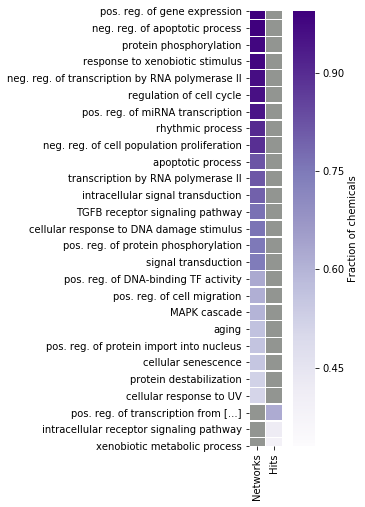

In [130]:
# now make a heatmap
f, ax = plt.subplots(figsize=(4,8))
# curr_cmap = sns.color_palette('Blues')
# curr_cmap.set_bad(color='gray')
sns.heatmap(df, cmap='Purples', square=True, linewidths=0.5,
            vmin=0.33, cbar_kws={'label': 'Fraction of chemicals'}, ax=ax)
ax.set_facecolor('xkcd:grey')
plt.ylabel("")

out_dir = results_dir+'/viz'
out_file = "%s/overlap-enrichment-heatmap.pdf" % (out_dir)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
plt.show()
plt.close()


In [116]:
df_counts['fraction']

TermID      Name                                                            
GO:0000122  negative regulation of transcription by RNA polymerase II           0.964646
GO:0000165  MAPK cascade                                                        0.601010
GO:0001934  positive regulation of protein phosphorylation                      0.752525
GO:0006366  transcription by RNA polymerase II                                  0.818182
GO:0006468  protein phosphorylation                                             0.979798
GO:0006915  apoptotic process                                                   0.823232
GO:0006974  cellular response to DNA damage stimulus                            0.762626
GO:0007165  signal transduction                                                 0.747475
GO:0007179  transforming growth factor beta receptor signaling pathway          0.767677
GO:0007568  aging                                                               0.565657
GO:0008285  negative regulation o

# Try also loading the functions present in CTD

In [131]:
def get_chemical_map(toxcast_data):
    """
    Map the chemical ID used in ToxCast to the CAS RN 
    """
    print("reading %s" % (toxcast_data.chemical_summary_file))
    df = pd.read_csv(toxcast_data.chemical_summary_file, header=0)
    cols = df.columns
    chemIDtoCAS  = dict(zip(df[cols[3]], df[cols[2]]))
    chemCAStoID  = dict(zip(df[cols[2]], df[cols[3]]))
    return chemIDtoCAS, chemCAStoID

In [132]:
import sys
sys.path.append("./src/")
import toxcast_utils as t_utils

kwargs = {}
kwargs['chem_func_file'] = "/data/jeff-law/projects/toxcast/2020-12-toxcast/tox_signaling_networks/inputs/ctd/2020-09-23/CTD_chem_go_enriched.tsv.gz"
kwargs['chemicals'] = "inputs/versions/2018_01-toxcast-d2d-p1_5-u1_25/sig-chemicals.txt"
chemicals = pd.read_csv(kwargs['chemicals'], sep='\t', header=None, comment='#')[0].tolist()
toxcast_data = t_utils.loadToxcastData()
chemIDtoCAS, chemCAStoID = get_chemical_map(toxcast_data)

func_col = kwargs.get('chem_func_col',4)
print("reading %s, using col %s" % (kwargs['chem_func_file'], func_col))
df_func = pd.read_csv(
    kwargs['chem_func_file'], sep='\t', compression='gzip', comment='#',
    header=None,
)
print(df_func.head())
df_func[2] = df_func[2].apply(lambda x: chemCAStoID.get(x))
df_func = df_func[df_func[2].isin(chemicals)]
chemicals_with_func = df_func[2].unique()
print("\t%d/%d significant chemicals are in this file" % (len(chemicals_with_func), len(chemicals)))

loading chemical map
reading inputs/toxcast-tox21-v3/Chemical_Summary_190708.csv
reading inputs/toxcast-tox21-v3/parsed/chem_rec_tfs.gmt. Use --forced to overwrite
reading inputs/toxcast-tox21-v3/parsed/chem_prot_hits.csv. Use --forced to overwrite
reading inputs/toxcast-tox21-v3/parsed/chem_prot_zscores.csv. Use --forced to overwrite
reading inputs/toxcast-tox21-v3/Chemical_Summary_190708.csv
reading /data/jeff-law/projects/toxcast/2020-12-toxcast/tox_signaling_networks/inputs/ctd/2020-09-23/CTD_chem_go_enriched.tsv.gz, using col 4
         0        1    2                   3   \
0  10074-G5  C534883  NaN  Biological Process   
1  10074-G5  C534883  NaN  Biological Process   
2  10074-G5  C534883  NaN  Molecular Function   
3  10074-G5  C534883  NaN  Molecular Function   
4  10074-G5  C534883  NaN  Molecular Function   

                                                  4           5   6   \
0  negative regulation of nitrogen compound metab...  GO:0051172   3   
1                     

In [134]:
# df_func['func_count'] = 
ctd_fracs = df_func[func_col].value_counts() / len(chemicals_with_func)
ctd_fracs = ctd_fracs[ctd_fracs > 0.5]
ctd_fracs

cellular response to chemical stimulus                                0.822785
response to chemical                                                  0.784810
response to organic substance                                         0.759494
cellular response to stimulus                                         0.759494
primary metabolic process                                             0.746835
                                                                        ...   
metal ion binding                                                     0.506329
cofactor binding                                                      0.506329
negative regulation of cellular macromolecule biosynthetic process    0.506329
cellular response to hormone stimulus                                 0.506329
phosphate-containing compound metabolic process                       0.506329
Name: 4, Length: 245, dtype: float64

In [135]:
df2 = df.copy()
df2['ctd_fracs'] = ctd_fracs
df2

,Networks,Hits,ctd_fracs
Name,,,
pos. reg. of gene expression,0.994949,NaN,NaN
neg. reg. of apoptotic process,0.994949,NaN,NaN
protein phosphorylation,0.979798,NaN,NaN
response to xenobiotic stimulus,0.979798,NaN,0.518987
neg. reg. of transcription by RNA polymerase II,0.964646,NaN,NaN
regulation of cell cycle,0.959596,NaN,NaN
pos. reg. of miRNA transcription,0.949495,NaN,NaN
rhythmic process,0.904040,NaN,NaN
neg. reg. of cell population proliferation,0.893939,NaN,NaN


In [136]:
# also try overlap of chemicals in general
df_func = pd.read_csv(
    kwargs['chem_func_file'], sep='\t', compression='gzip', comment='#',
    header=None,
)

In [259]:
# # limit to chemicals with at least 25 or more terms
# num_terms = df_func[0].value_counts()
# df_func = df_func[df_func[0].isin((num_terms >= 25).index)]
# print(len(df_func))

6065552


In [137]:
ctd_fracs = df_func[func_col].value_counts() / len(df_func[0].unique())
ctd_fracs = ctd_fracs[ctd_fracs > 0.5]
ctd_fracs

cellular response to chemical stimulus    0.567754
response to chemical                      0.563244
response to organic substance             0.538868
response to oxygen-containing compound    0.537140
cellular response to stimulus             0.518426
response to drug                          0.518138
response to stimulus                      0.516603
cellular response to organic substance    0.515259
response to stress                        0.505950
regulation of biological quality          0.503839
Name: 4, dtype: float64

In [138]:
ctd_counts = df_func[func_col].value_counts()
ctd_counts = ctd_counts[ctd_counts.index.isin(df.index)]
ctd_counts = ctd_counts[ctd_counts >= 1000]
print("%d terms" % (len(ctd_counts)))
ctd_counts

14 terms


apoptotic process                           4950
signal transduction                         4811
intracellular signal transduction           4660
protein phosphorylation                     4105
transcription by RNA polymerase II          3561
aging                                       3517
MAPK cascade                                3202
response to xenobiotic stimulus             3202
regulation of cell cycle                    3031
cellular response to DNA damage stimulus    2738
rhythmic process                            2400
xenobiotic metabolic process                2363
intracellular receptor signaling pathway    1948
cellular response to UV                     1607
Name: 4, dtype: int64

In [139]:
df2 = df.copy()
df2['CTD count'] = ctd_counts
df2.head()

,Networks,Hits,CTD count
Name,,,
pos. reg. of gene expression,0.994949,NaN,NaN
neg. reg. of apoptotic process,0.994949,NaN,NaN
protein phosphorylation,0.979798,NaN,4105.0
response to xenobiotic stimulus,0.979798,NaN,3202.0
neg. reg. of transcription by RNA polymerase II,0.964646,NaN,NaN


In [271]:

df2.index = [x.replace('negative','neg.').replace('positive','pos.').replace('regulation', 'reg.') for x in df2.index]

outputs/2018_01-toxcast-d2d-p1_5-u1_25/weighted/stats/viz/overlap-enrichment-heatmap-ctd.pdf


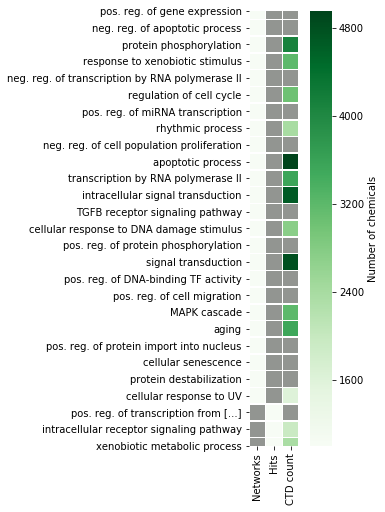

In [140]:
# now make a heatmap
f, ax = plt.subplots(figsize=(4,8))
# curr_cmap = sns.color_palette('Blues')
# curr_cmap.set_bad(color='gray')
# sns.heatmap(df, cmap='YlOrBr', square=True, 
# sns.heatmap(df2['CTD count'], cmap='Greens', square=True, linewidths=0.5,
sns.heatmap(df2, cmap='Greens', square=True, linewidths=0.5,
            vmin=1000, cbar_kws={'label': 'Number of chemicals'}, ax=ax)
ax.set_facecolor('xkcd:grey')
plt.ylabel("")

out_dir = results_dir+'/viz'
out_file = "%s/overlap-enrichment-heatmap-ctd.pdf" % (out_dir)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
plt.show()
plt.close()
